##### Classification model using the MNIST dataset, which is a set of 70,000 small images of digits handwritten. Each image is labeled with the digit it represents.

In [1]:
###### Load the data set
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
# mnist[:,:5]

####### Data is unsorted, to get the sorted data, we will use sort_by_target function

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
    

sort_by_target(mnist) # fetch_openml() returns an unsorted dataset

In [ ]:
######### A data key containing an array with one row per instance and one column per feature
######### A target key containing an array with the labels

In [3]:
mnist.data.shape

(70000, 784)

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape ### There are 70,000 images, and each image has 784 features

(70000, 784)

In [6]:
y.shape

(70000,)

####### take a peek at one digit from the dataset by taking instance’s feature vector, reshape it to a 28×28 array, and display it using Matplotlib’s function imshow()

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

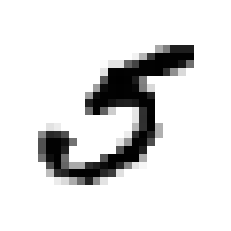

In [8]:
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show() ### image looks like 5

In [9]:
y[36000] ### yes, that's 5

5

####### The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images)

In [10]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:],y[:60000],y[60000:]

In [11]:
###### Shuffle training set
import numpy as np

shuffle_index = np.random.permutation(60000)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

####### Let's simplify problem by indentifying one digit i.e. 5 which is binary classifier capable of distinguish between two class e.g. class 5 or not class 5

In [12]:
y_train_5 = (y_train == 5) ### True for all 5's and False for others
y_test_5 = (y_test == 5)

######  We use stochastic Descent classifier to train the model as this classier capable handling very large dataset efficiently

In [13]:
from sklearn.linear_model import SGDClassifier

# random_seed = 43
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=43)
x_train.shape
y_train_5.shape
sgd_clf.fit(x_train, y_train_5)

# x_train.shape

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=43, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [14]:
#### to detect the image of 5
sgd_clf.predict([some_digit])

array([ True])

## Evaluate Models Performance Measures

#### Measuring Accuracy Using cross validation 

####### Accuracy is defined as the ratio of correctly predicted example by the total example

####### Accuracy = (Number of correct prediction) / (Total number of Prediction)       

####### The class performs stratified sampling (as explained in Chapter 2) to produce folds that contain a representative ratio StratifiedKFold of each class.

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=43)

for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)    ## At each iteration the code creates a clone of the classifier 
    x_train_folds = x_train[train_index]
    y_train_folds = (y_train_5[train_index])
    x_test_fold = x_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(x_train_folds, y_train_folds) ## trains that clone on the training folds
    y_pred = clone_clf.predict(x_test_fold) ## makes predictions on the test fold.
    n_correct = sum(y_pred == y_test_fold) ## it counts the number of correct predictions
    print(n_correct/len(y_pred)) ## outputs the ratio of correct predictions.

0.962
0.9187
0.96335


####### Let’s use the cross_val_score() function to evaluate your SGDClassifier model using K-fold crossvalidation,
with three folds.

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.962  , 0.9187 , 0.96335])

####### 95% accuracy (ratio of correct predictions) on all cross-validation folds?

####### Let's check with dumb classifier that just classifies every single image in the “not-5” class

In [19]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring="accuracy") ### 90% accuracy

array([0.9111 , 0.91   , 0.90785])

####### This is because only 10% of the images are 5. if you always guess that an image is not a 5, you will be right about 90% of the time.
####### That's why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

### Confusion Matrix

####### A confusion matrix shows the number of correct and incorrect predictions made by the classification model compared to the actual outcomes (target value) in the data. The matrix is NxN, where N is the number of target values (classes, in this case 2 classes as class 5 and class not 5). Performance of such models is commonly evaluated using the data in the matrix.



Confusion Matrix	         Target	 
                    Negative	   Positive	
Model	Negative	   a	         b	           Negative Predictive Value	a/(a+b)
	    Positive	   c	         d	           Positive Predictive Value	d/(d+c)
 	              Specificity	  Sensitivity	       Accuracy = (a+d)/(a+b+c+d)
	                a/(a+c)	       d/(d+b)	

Accuracy : the proportion of the total number of predictions that were correct.
Positive Predictive Value or Precision : the proportion of positive cases that were correctly identified.
Negative Predictive Value : the proportion of negative cases that were correctly identified.
Sensitivity or Recall : the proportion of actual positive cases which are correctly identified. 
Specificity : the proportion of actual negative cases which are correctly identified. 

####### To perform confusion matrix, we use the cross_val_predict() function which perform similar to cross_val_score() function, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

####### Now get the confusion matrix by passing the target classes (y_train_5) and the predicted classes (y_train_pred) to the confusion_matrix() function.

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52148,  2431],
       [  688,  4733]], dtype=int64)

####### Each row in a confusion matrix represents an actual class, while each column represents a predicted class.

Confusion Matrix	            Predicted	 
                        Negative	   positive	
    Actual	Negative	 52148	         2431	         
            Positive	 688	         4733	         
                          
    
####### The first row of this matrix considers non-5-images (the negative class) and second row consider as 5-imge (positve class)
####### The First column of Matrix consider as non-5-images predicted (Negative) and second column as 5-images predicted (Positve)
####### 52148 of them were correctly classified as non-5-images (true negatives) TN
####### 2431 were wrongly classified/predicted as 5-images (false positives)FP
####### 688 were wrongly classified as non-5-images (false negatives)FN
####### 4733 were correctly classified as 5s (true positives)TP

#### Precision

####### The confusion matrix gives you a lot of information, but sometimes it is more preferale concise metric.
####### Interestingly, to look at the accuracy of the positive predictions, called the precision of the classifier

#######                        Precision = TP/(TP + FP) 

In [22]:
from sklearn.metrics import precision_score

precision_score(y_train_5, y_train_pred)

0.6606644332774986

#### Recall

####### A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct
#######(precision = 1/1 = 100%). This would not be useful as classifier would ignore all but one positive instance.
####### So precision is typically used along with another metric called recall, sensitivity or true positive rate(TPR)

#######                       Recall = TP/(TP +FN)

In [23]:
from sklearn.metrics import recall_score

recall_score(y_train_5, y_train_pred)

0.8730861464674414

#### F1 Score                                         


####### It is often convenient to combine precision and recall into a single metric called the F1 score. if you need a to compare two classifiers. The F1 score is the harmonic mean of precision and recall

#######                      F1 score = 2 x [(Precision x Recall)/(Precision + Recall)]  

In [24]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7521652761223678

##### Precision/Recall Tradeoff

####### The F1 score favors classifiers that have similar precision and recall, This is not always what you want, in some contexts you mostly care about precision, and in other contexts you really care about recall. 

####### For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product

####### On the other hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall

####### Increasing precision reduces recall, and vice versa. This is called the precision/recall tradeoff. Unfortunately, you can’t have it both ways.

####### To understand precision recall tradeoff, use SGDClassifier
####### For each instance, SGD Classifier computes a score based on a decision function, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class.

####### To find out decision function, we use cross_val_predict() function by specifying to return decision scores instead of predictions

In [25]:
from sklearn.metrics import precision_recall_curve

y_score = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_score) 

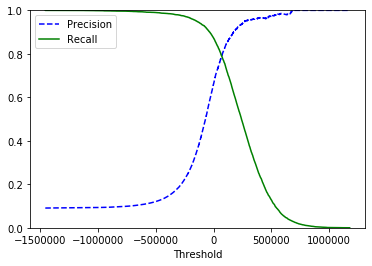

In [26]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

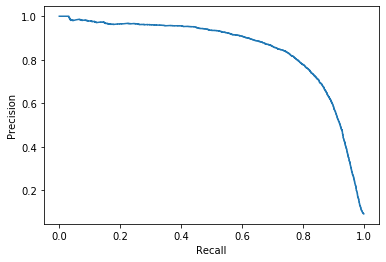

In [27]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

####### The precision starts to fall sharply around 80% recall
####### Selection of precision recall tradeoff depend upon project and problem
####### In this case, we choose 90% precision
####### from the first plot, for 90% precison, we need to take 70000 threshold

In [28]:
y_train_pred_90 = (y_score > 70000)

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.7883023726319661

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.7906290352333518

##### The ROC Curve

####### ROC(Receiver Operating Characteristic) Curve similar to precision and recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR is the ratio of negative instances that are incorrectly classified as positive)
####### FPR = 1 - TNR (the ratio of negative instances that are correctly classified as negative,also called specificity)
####### Hence the ROC curve plots sensitivity (recall) versus 1 – specificity

In [31]:
### To plot the ROC curve, first compute the TPR and FPR for various threshold values, using the roc_curve() 

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_score)

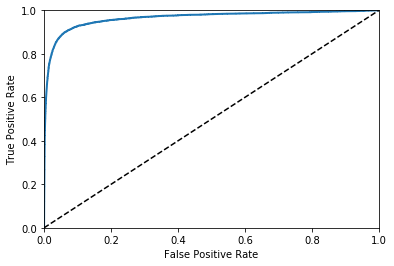

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

####### Again there is a tradeoff, the higher the recall (TPR), the more false positives (FPR) the classifier produce.
####### The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

####### The area under the curve (AUC) is measure to compare classifiers. A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [33]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_score) #### Close to 1

0.9648364113169337

####### Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier
####### RandomForestClassifier class does not have a decision_function() method Instead it use predict_proba() method
####### The method returns an array containing a row per instance and a column per predict_proba() class, each containing the probability that the given instance belongs to the given class

In [34]:
from sklearn.ensemble import RandomForestClassifier
import warnings;warnings.simplefilter('ignore')
forest_clf = RandomForestClassifier(random_state=43)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method="predict_proba")

In [35]:
#### To plot ROC Curve, we need score not probablities. Solution to this use positive class probablities as score

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

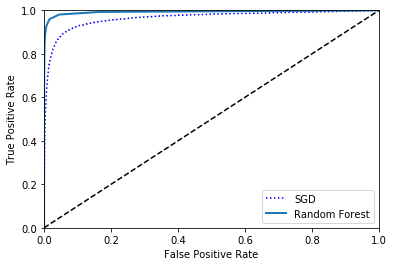

In [36]:
#### Plot ROC curve

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

######## the RandomForestClassifier’s ROC curve looks much better than the SGDClassifier’s ROC curve as it comes much closer to the top-left corner.

####### let's check ROC AUC Score

In [37]:
roc_auc_score(y_train_5, y_scores_forest) ## score is 0.9937 close to 1

0.9929907707387147

### Multiclass Classification

####### multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.


####### Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers.

##### one-versus-all (OvA)
####### A system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score.

#####  one-versus-one (OvO) 
####### Train a binary classifier for every pair of digits i.e. one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers where N = 10.

####### Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification
task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO, as with OvA it scale poorly with size of training set)

####### Let’s try this with the SGDClassifier

In [38]:
sgd_clf.fit(x_train, y_train) ### not binary class y_train_5, multiclass y_train
sgd_clf.predict([some_digit])

array([5], dtype=int8)

######## This code trains the SGDClassifier on the training set using the original target classes from 0 to 9 (y_train), instead of the 5-versus-all target classes (y_train_5). Then it makes correct prediction

####### Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.

####### Let's call the decision_function() method. Instead of returning just one score per instance, it now returns 10 scores, one per class

In [39]:
some_digit_score = sgd_clf.decision_function([some_digit])
some_digit_score

array([[   1381.07098258, -578690.8981891 , -389739.9742663 ,
        -116164.4063564 , -371825.97985093,  149637.94736365,
        -712425.73582688, -286274.0304602 , -541868.19587965,
        -591096.54390404]])

In [40]:
##### The highest score is indeed the one corresponding to class 5

np.argmax(some_digit_score)

5

In [41]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

####### If you want to ScikitLearn to use one-versus-one or one-versus-all, you can use the OneVsOneClassifier or OneVsRestClassifier classes by creating an instance and pass a binary classifier to its constructor.

In [42]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=43))
ovo_clf.fit(x_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [42]:
###### code creates a multiclass classifier using the OvO strategy based on a SGDClassifier

len(ovo_clf.estimators_)

45

####### Let's train RandomForestClassifier
####### Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances into multiple classes.

In [43]:
forest_clf.fit(x_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

####### call predict_proba() to get the list of probabilities that the classifier assigned to each instance for each class

In [44]:
forest_clf.predict_proba([some_digit])

array([[0.2, 0. , 0. , 0. , 0. , 0.7, 0.1, 0. , 0. , 0. ]])

####### We can see that the classifier is fairly confident about its prediction, the 0.7 at the 5th index in the array
means that the model estimates an 70% probability that the image represents a 5. It also thinks that the
image could instead be a 0 or a 6 (20% and 10% respectively).

####### Let’s evaluate the SGDClassifier’s accuracy using the cross_val_score() function

In [45]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.88557289, 0.8839942 , 0.86567985])

####### It gets over 86.39% on all test folds

####### Let's scale the imput and check

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90786843, 0.91054553, 0.91058659])

####### Scaling the input get's 90% on all test folds

### Error Analysis

####### Here, we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

####### First, you can look at the confusion matrix. You need to make predictions using the cross_val_predict() function, then call the confusion_matrix() function.

In [47]:
y_trian_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

In [48]:
conf_mx

array([[5564,  359,    0,    0,    0,    0,    0,    0,    0,    0],
       [6604,  138,    0,    0,    0,    0,    0,    0,    0,    0],
       [5833,  125,    0,    0,    0,    0,    0,    0,    0,    0],
       [5524,  607,    0,    0,    0,    0,    0,    0,    0,    0],
       [5715,  127,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 688, 4733,    0,    0,    0,    0,    0,    0,    0,    0],
       [5664,  254,    0,    0,    0,    0,    0,    0,    0,    0],
       [6191,   74,    0,    0,    0,    0,    0,    0,    0,    0],
       [5272,  579,    0,    0,    0,    0,    0,    0,    0,    0],
       [5781,  168,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

####### That’s a lot of numbers. It’s often more convenient to look at an image representation of the confusion matrix, using Matplotlib’s function matshow()

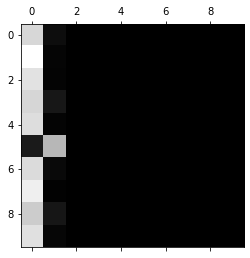

In [49]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

####### Since, most images are vertical that means classifier does not classify correctly 

####### Let’s focus the plot on the errors. First, you need to divide each value in the confusion matrix by the
number of images in the corresponding class, so you can compare error rates instead of absolute number of errors

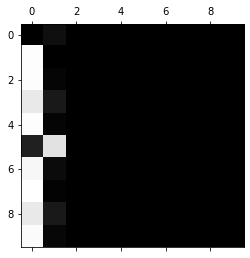

In [50]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

### let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

####### Remember that rows represent actual classes, while columns represent predicted classes.
####### Columns are dark from 1 to 9 means that 1 to 9 classify correctly
####### Column of 0 pretty light that means column 0 does not classify correctly

### Multilabel Classification

####### In some cases you may want your classifier to output multiple classes for each instance. 
####### For example, consider a face-recognition classifier: what should it do if it recognizes several people on the same picture it should attach one label per person it recognizes. Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then when it is shown a picture of Alice and Charlie, it should output [1, 0, 1]
(meaning “Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple binary labels is called a multilabel classification system.

####### Let's creates a y_multilabel array containing two target labels for each digit image. The first indicates whether or not the digit is large (7, 8, or 9) and the second indicates whether or not it is odd. The next lines create a KNeighborsClassifier instance (which supports multilabel classification, but not all classifiers do) and we train it using the multiple targets array

In [51]:
y_train_large = (y_train >= 7) ### first indicates whether or not the digit is large (7, 8, or 9)
y_train_odd = (y_train % 2 == 1) ### the second indicates whether or not it is odd
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel.shape

(60000, 2)

In [52]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(x_train, y_multilabel)
# y_train.shape

(60000,)

In [52]:
knn_clf.predict([some_digit])

array([[False,  True]])

####### The digit 5 is not large (False) and odd (True).

####### There are many ways to evaluate a multilabel classifier, one approach is to measure the F1 score for each individual label then compute the average score

In [53]:
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")
# f1_score(y_train, y_train_knn_pred, average="weighted")

KeyboardInterrupt: 

### Multioutput Classification

####### It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

####### To illustrate example of a multioutputclassification system let’s build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities
####### the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255).

####### Let's add noise to training and test set's pixel intensities using NumPy’s randint() function

In [ ]:
noise = np.random.randint(0, 100, (len(x_train), 784))
x_train_mod = x_train + noise
noise = np.random.randint(0, 100, (len(x_test), 784))
x_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test

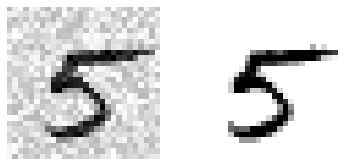

In [55]:
import matplotlib as mpl

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_index = 5500
plt.subplot(121); plot_digit(x_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
# save_fig("noisy_digit_example_plot")
plt.show()

####### On the left is the noisy input image, and on the right is the clean target image.

####### Now, train the classifier and make it clean this image

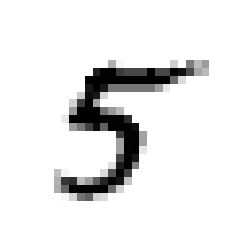

In [56]:
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predict([x_test_mod[some_index]])
plot_digit(clean_digit)

######## Looks close enough to the target